# Digital Image Processing - Assignment 2

**Imports**

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

**Utility functions from Assignment-1**

In [2]:
def pascal_row(k):
    ans = [1]
    for row in range(1, k):
        ans = ans[1:] + ans[:-1]
        ans = np.concatenate(([1], ans, [1]))
    return np.array(ans)

def approx1DGaussFilter1(k):
    gg = np.array([pascal_row(k)])
    gg = gg.T@gg
    gg = gg/np.sum(gg)
    return gg

def convert_to_grey(image1):
    blue_channel  = image1[:,:,0]
    green_channel = image1[:,:,1]
    red_channel   = image1[:,:,2]
    # Taking intensity value as a weighted sum of RGB
    grey_img = 0.3*red_channel + 0.59*green_channel + 0.11*blue_channel
    grey_img = np.stack((grey_img,)*3, axis=-1)
    grey_img = grey_img.astype(int)
    return grey_img

def effMeanFilter(img, k):
    img = img[:, :, 0]
    res = np.zeros((img.shape[0], img.shape[1]))
    
    img = padded_img(img, k)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if x>0: img[x][y] += img[x-1][y]
            if y>0: img[x][y] += img[x][y-1]
            if x>0 and y>0: img[x][y] -= img[x-1][y-1]
    
    for x in range(k-1, img.shape[0]):
        for y in range(k-1, img.shape[1]):
            sm = img[x][y]
            if x>=k: sm = sm - img[x-k][y]
            if y>=k: sm = sm - img[x][y-k]
            if x>=k and y>=k: sm = sm + img[x-k][y-k]
            sm = sm/(k*k)
            sm = int(sm)
            res[x-(k-1)][y-(k-1)]+=sm

    res = res.astype(np.uint8)
    res = np.stack((res,)*3, axis=-1)
    return res  

def gauss_2D(x, y, std):
    return np.exp(-(x*x+y*y)/(2*std*std))/np.sqrt(2*np.pi*std*std)

def gaussKernelGenerator(k, var):
    res = np.zeros((k, k))
    std = np.sqrt(var)
    for x in range(k):
        for y in range(k):
            res[x][y] += gauss_2D(x-(k//2), y-(k//2), std)
    res = res/np.sum(res)
    return res

def padded_img(img, k):
    [ogh, ogw] = img.shape
    sz = k//2
    gg = np.zeros((img.shape[0] + 2*sz, img.shape[1] + 2*sz))
    gg[sz:sz+ogh,sz:sz+ogw] = img
    return gg

def convolve(img, kernel):
    img = img.astype(np.float64)
    kernel = kernel.astype(np.float64)
    k = kernel.shape[0]
    img = img[:, :, 0]
    res = np.zeros((img.shape[0], img.shape[1]))
    img = padded_img(img, k)
    for x in range(res.shape[0]):
        for y in range(res.shape[1]):
            res[x][y]+= max(0, np.sum(img[x:x+k,y:y+k]*kernel))
    res = res.astype(np.int)
    return res

### 1. Blurry Moments

In [3]:
def high_boost_filter(img, size):
    kernel = approx1DGaussFilter1(5)
    demn = convolve(img, kernel)
    img = img[:,:,0]
    details = img-demn
    res = img+details
    res = np.clip(res, a_min=0, a_max=255)
    return res

def unsharp_masking(img, size):
    kernel = np.full((size, size), -1)
    kernel[size//2][size//2] = size*size-1
    demn = convolve(img, kernel)
    img = img[:,:,0]
    res = img+demn
    res = res.astype(np.float64)
    res = 255.0 * (res-np.min(res))/(np.max(res)-np.min(res))
    res = res.astype(np.uint8)
    return res

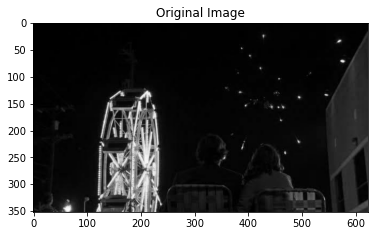

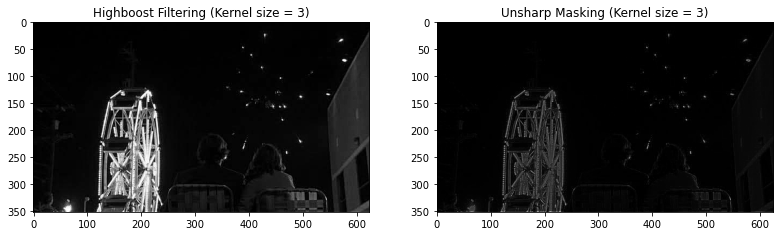

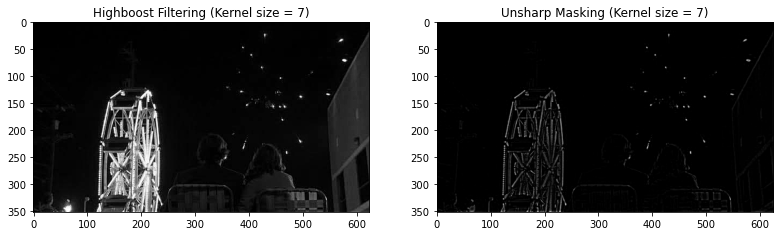

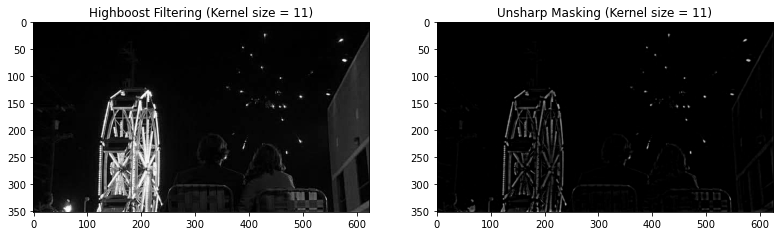

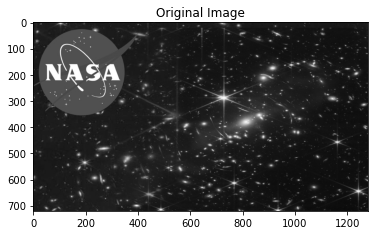

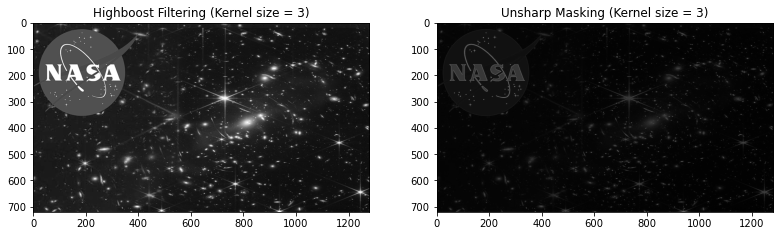

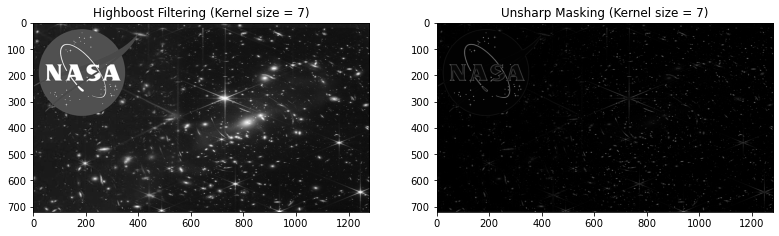

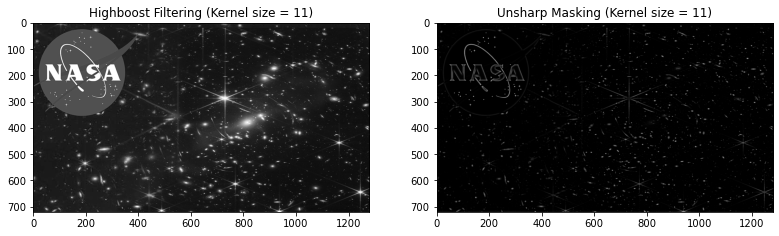

In [4]:
images = ['../images/Jam.jpg', '../images/webb.jpg']

for image in images:

    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    grey_img = convert_to_grey(img)
    plt.imshow(grey_img)
    plt.title("Original Image")
    plt.show()

    filter_sizes = [3, 7, 11]

    for size in filter_sizes:
        f, ax = plt.subplots(1, 2, figsize=(13.25, 7))
        ax[0].imshow(high_boost_filter(grey_img, size), cmap='gray')
        ax[0].set_title(f"Highboost Filtering (Kernel size = {size})")
        ax[1].imshow(unsharp_masking(grey_img, size), cmap='gray')
        ax[1].set_title(f"Unsharp Masking (Kernel size = {size})")
        plt.show()

**Alternate solution**  
  
Instead of separately computing the double derivative or smoothened image, we can directly convolve with the filter structure described below:
<br></br>
<img src="../images/Q1.png" width="512">

In [5]:
def sharpen_img(img, A, size):
    kernel = np.full((size, size), -1)
    kernel[size//2][size//2] = A*size*size-1
    return convolve(img, kernel)

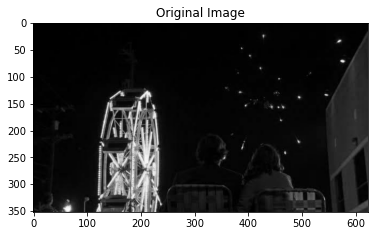

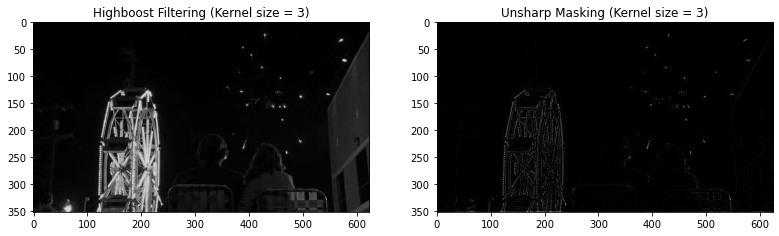

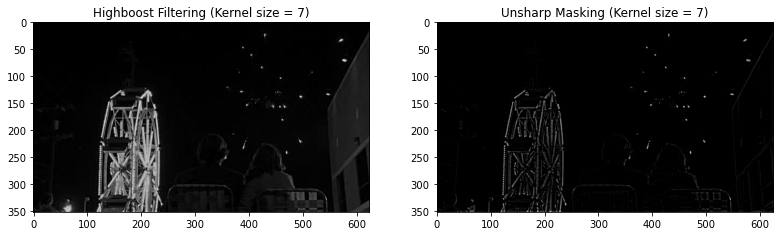

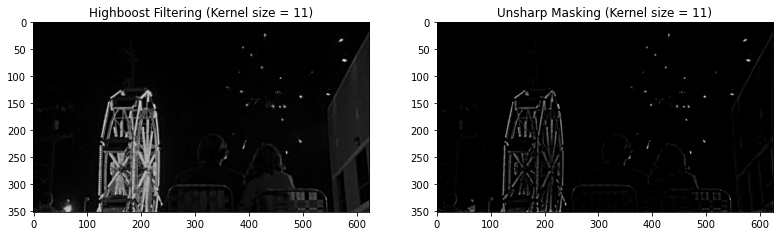

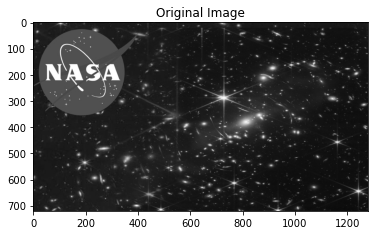

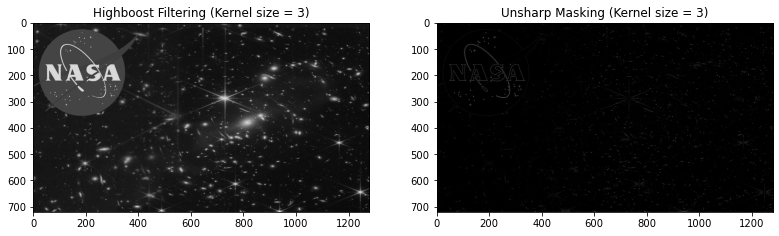

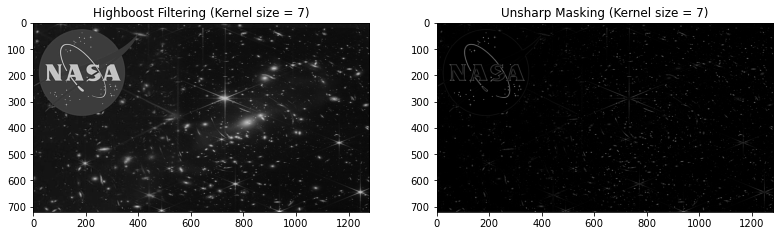

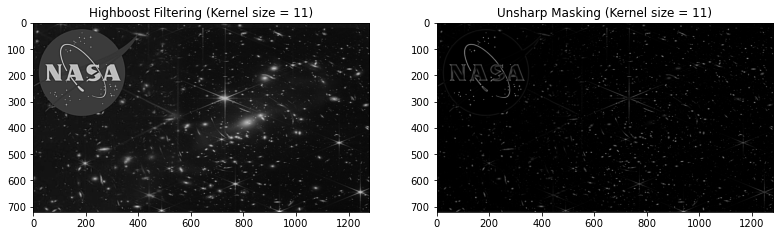

In [6]:
images = ['../images/Jam.jpg', '../images/webb.jpg']

for image in images:

    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    grey_img = convert_to_grey(img)
    plt.imshow(grey_img)
    plt.title("Original Image")
    plt.show()

    filter_sizes = [3, 7, 11]

    for size in filter_sizes:
        f, ax = plt.subplots(1, 2, figsize=(13.25, 7))
        ax[0].imshow(sharpen_img(grey_img, 3, size), cmap='gray')
        ax[0].set_title(f"Highboost Filtering (Kernel size = {size})")
        ax[1].imshow(sharpen_img(grey_img, 1, size), cmap='gray')
        ax[1].set_title(f"Unsharp Masking (Kernel size = {size})")
        plt.show()

**Observations**  

In case of unsharp masking, the edges get more prominent compared to highboost filtering, and the intensity of the edges further increases with kernel size. For highboost filtering too, the images seems to get clearer with increasing kernel size (notice the cross(?) on the top of the ferris wheel in different results.)

### 2. Intentionally Blurry Moments

In [7]:
def padded_rgb(img, k):
    sz = k//2
    img = cv2.resize(img, (img.shape[1]+2*sz, img.shape[0]+2*sz), interpolation = cv2.INTER_AREA)
    plt.show()
    return img

def bilateral_filter(img, sigma_c, sigma_s, k):
    
    res = np.zeros((img.shape))
    img = padded_rgb(img, k)
    gaussian_kernel = gaussKernelGenerator(k, sigma_c**2)
    img = img.astype(np.float64)
    
    for i in range(res.shape[0]):
        for j in range(res.shape[1]):
            for ch in range(res.shape[2]):
                subpart = img[i: i+k, j: j+k, ch]
                photometric_kernel = np.exp(-((subpart - img[i][j][ch])**2)/(2*sigma_s*sigma_s))
                kernel = gaussian_kernel * photometric_kernel
                res[i][j][ch] = np.sum(subpart*kernel) / np.sum(kernel)
    
    res = res.astype(np.uint8)
    return res

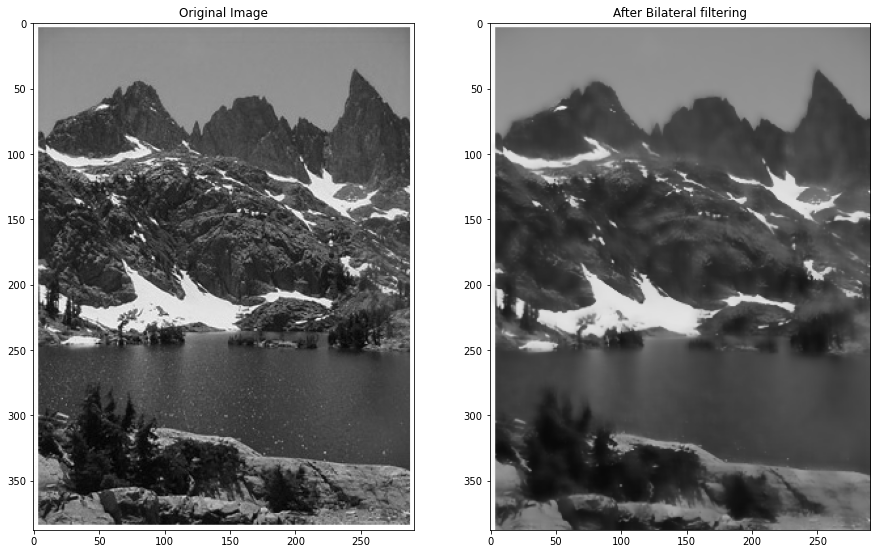

In [8]:
img = cv2.imread('../images/lakeside.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
grey_img = convert_to_grey(img)
grey_img = grey_img.astype(np.uint8)

demn = bilateral_filter(grey_img, 10, 35, 7)

f, ax = plt.subplots(1, 2, figsize=(15, 30))
ax[0].imshow(grey_img, cmap='gray')
ax[0].set_title(f"Original Image")
ax[1].imshow(demn, cmap='gray')
ax[1].set_title(f"After Bilateral filtering")
plt.show()

In [9]:
c_vals = np.array([10, 25, 100, 250])
s_vals = np.array([10, 25, 100, 250])

imgs = []

for x, c in enumerate(c_vals):
    for y, s in enumerate(s_vals):
        imgs.append(bilateral_filter(np.copy(grey_img), c, s, 7))

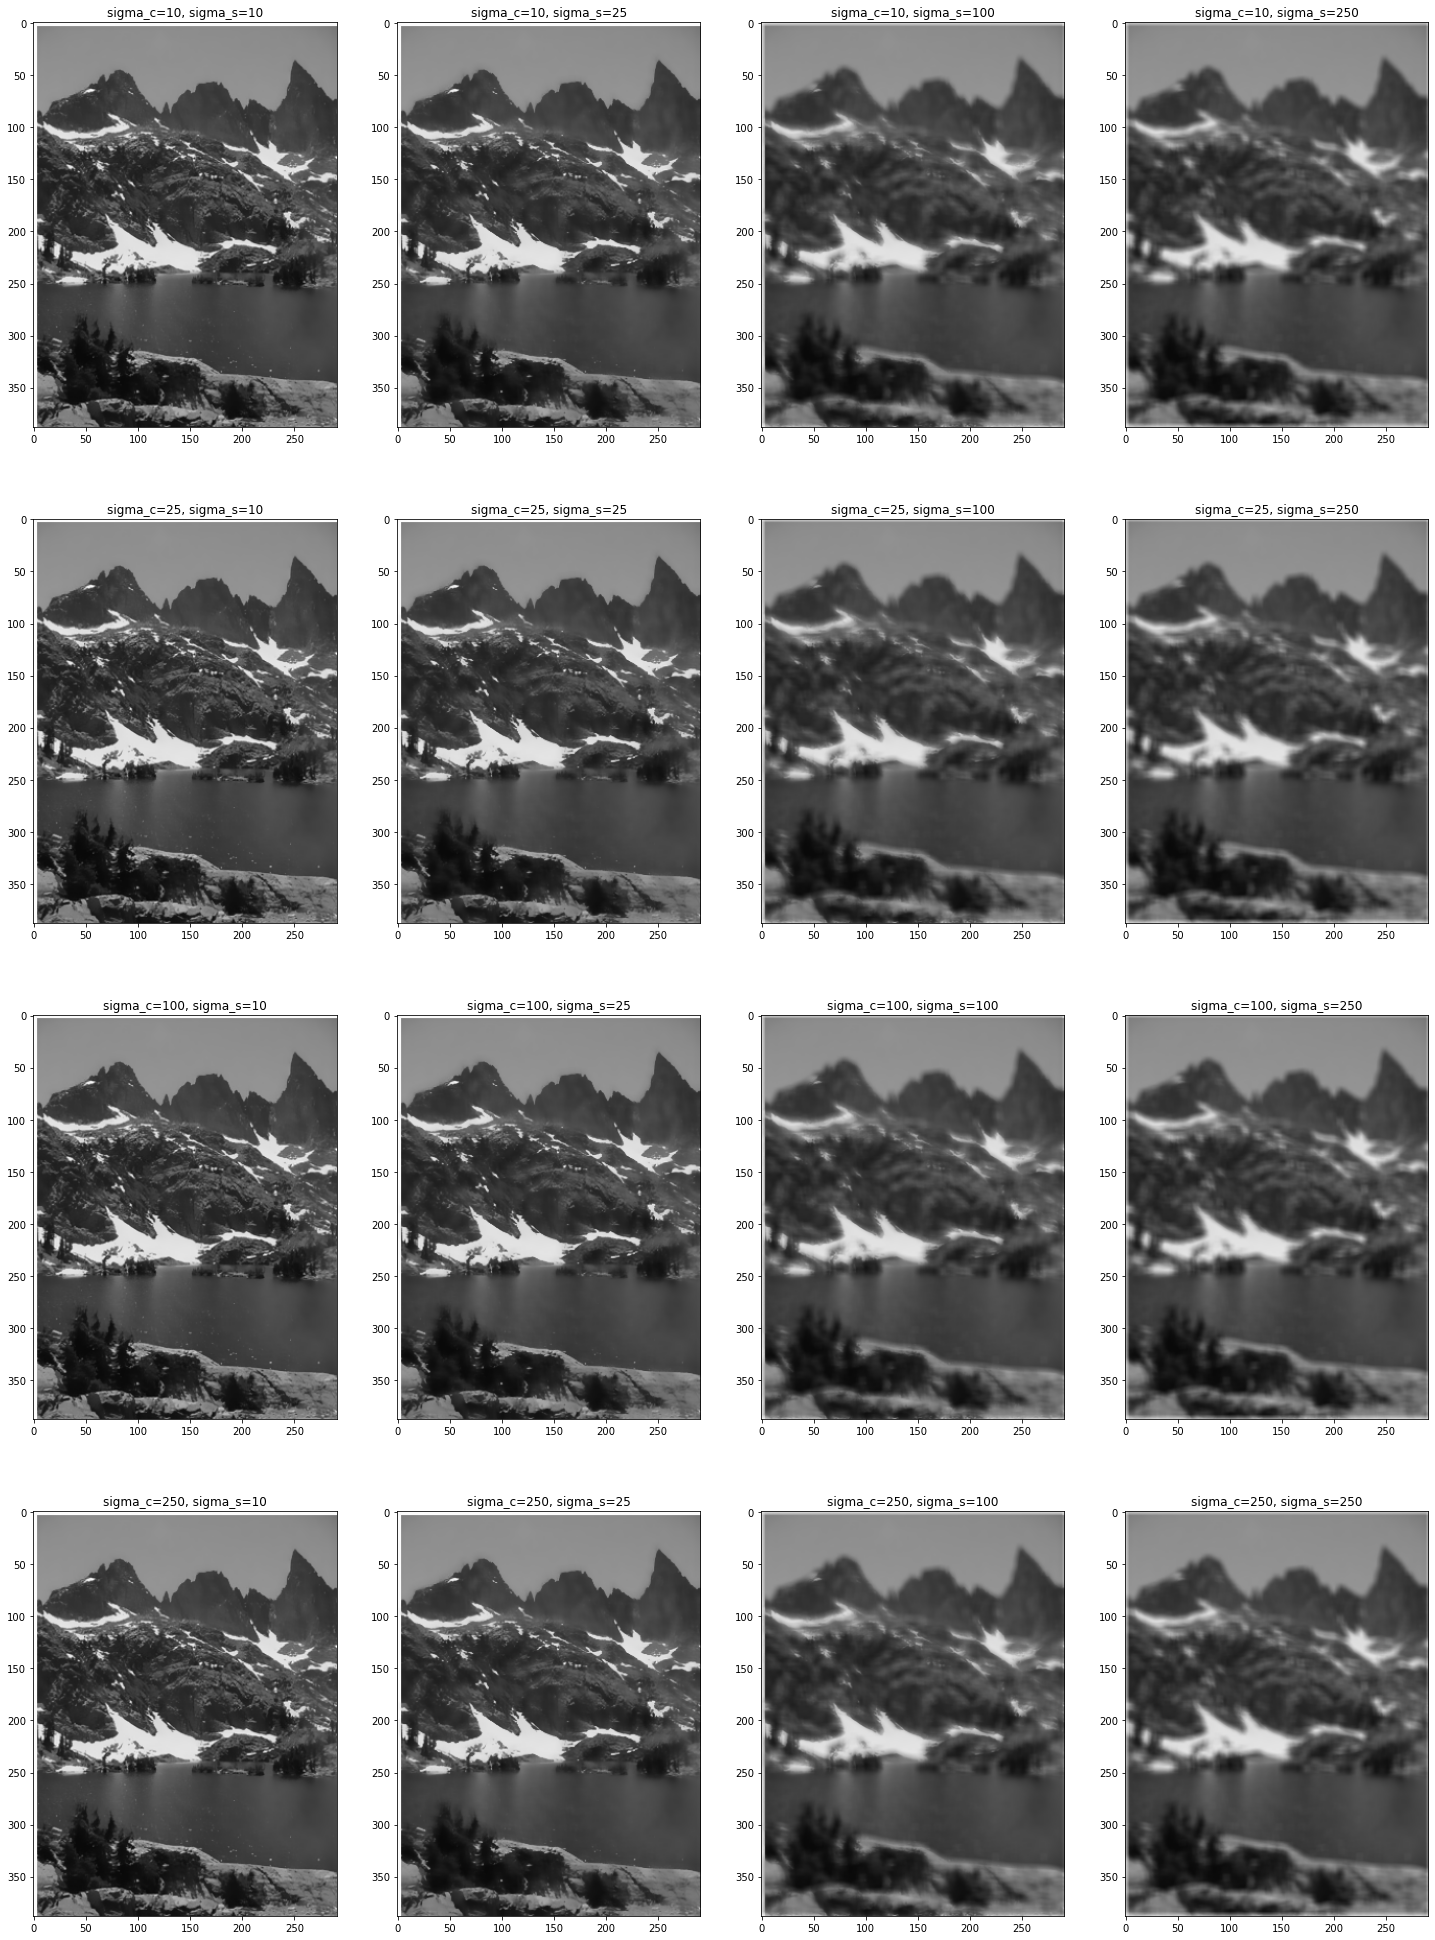

In [10]:
f, ax = plt.subplots(c_vals.shape[0], s_vals.shape[0], figsize=(25, 35))
idx=0

for x, c in enumerate(c_vals):
    for y, s in enumerate(s_vals):
        plt.subplot(c_vals.shape[0], s_vals.shape[0], s_vals.shape[0]*x+y+1)
        plt.title(f"sigma_c={c}, sigma_s={s}")
        plt.imshow(imgs[idx])
        idx+=1

plt.show()

**Observations**  
$\sigma_s$ corresponds to the photometric filtering and $\sigma_c$ corresponds to the geometric filtering. By taking the different combination of these sigmas, it can be seen that on increasing $\sigma_s$, the regions inside the boundaries (interior sections) get more and more smoothened out, but the boundaries themselves are preserved. On the other hand, on increasing $\sigma_s$, the overall blurring increases, which includes the boundaries (the edges start to spread out.)

### 3. Pam and Graphic Design

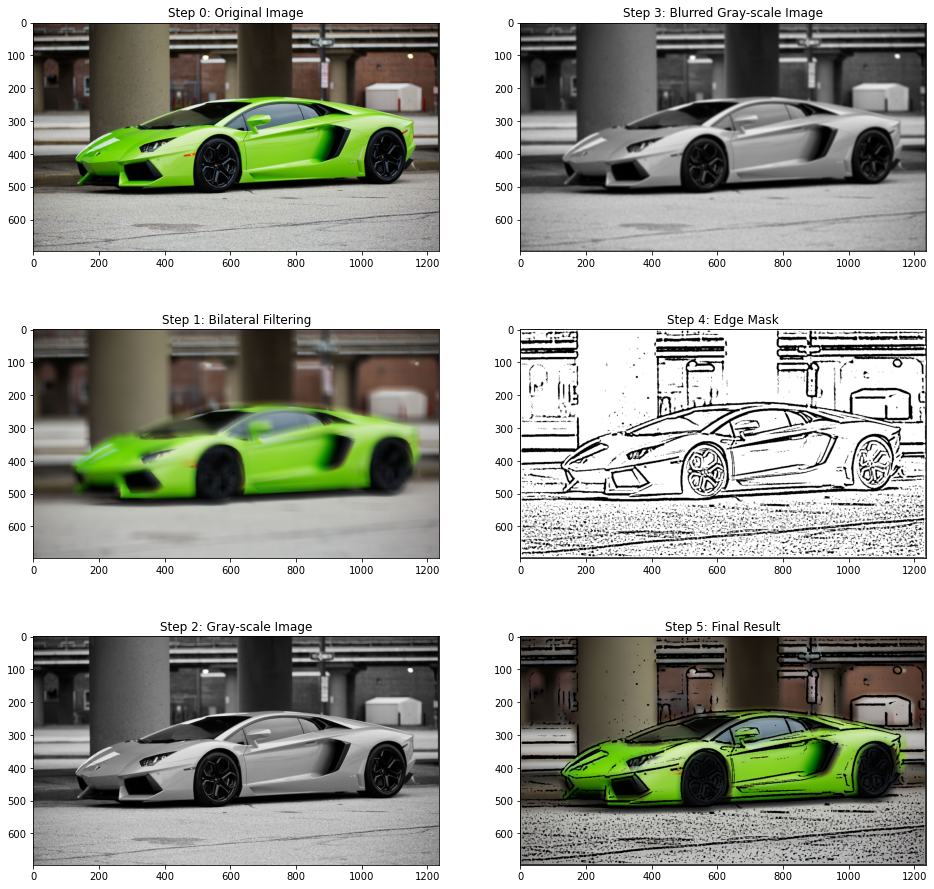

In [11]:
# Step 0: Reading the image
img = cv2.imread('../images/Q3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Step 1: Applying bilateral filter
blur_img = bilateral_filter(img,55,105,25)

# Step 2: Generating the grey-scale image
grey_img = convert_to_grey(img)

# Step 3: Blurring the grey-scale image
blur_grey_img = effMeanFilter(grey_img, 7)
blur_grey_img = blur_grey_img[:,:,0]
blur_grey_img = blur_grey_img.astype(np.uint8)

# Step 4: Generating the edge mask
blur_grey_img = blur_grey_img.astype(np.uint8)
edge_mask = cv2.adaptiveThreshold(np.copy(blur_grey_img),255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
edge_mask = np.stack((edge_mask,)*3, axis=-1)
edge_mask = edge_mask.astype(np.uint8)

# Step 5: Combining the edge mask with bilateral image
res = edge_mask & blur_img

# Plotting all the images
f, ax = plt.subplots(3, 2, figsize=(16,16))
ax[0][0].imshow(img)
ax[0][0].set_title('Step 0: Original Image')
ax[1][0].imshow(blur_img)
ax[1][0].set_title('Step 1: Bilateral Filtering')
ax[2][0].imshow(grey_img)
ax[2][0].set_title('Step 2: Gray-scale Image')
ax[0][1].imshow(blur_grey_img, cmap='gray')
ax[0][1].set_title('Step 3: Blurred Gray-scale Image')
ax[1][1].imshow(edge_mask)
ax[1][1].set_title('Step 4: Edge Mask')
ax[2][1].imshow(res)
ax[2][1].set_title('Step 5: Final Result')
plt.show()

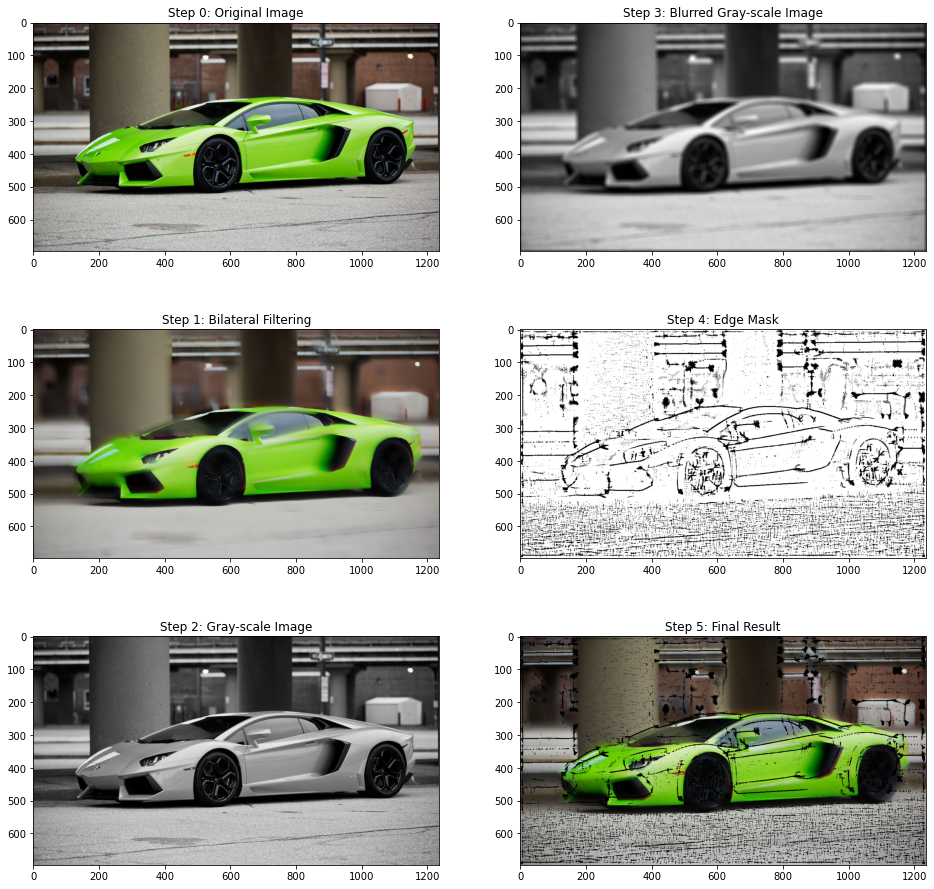

In [12]:
# Step 0: Reading the image
img = cv2.imread('../images/Q3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Step 1: Applying bilateral filter
blur_img = bilateral_filter(img,35,55,25)

# Step 2: Generating the grey-scale image
grey_img = convert_to_grey(img)

# Step 3: Blurring the grey-scale image
blur_grey_img = effMeanFilter(grey_img, 15)
blur_grey_img = blur_grey_img[:,:,0]

# Step 4: Generating the edge mask
[dim0, dim1] = blur_grey_img.shape
edge_mask = np.zeros((dim0, dim1))
sz = 7
d = sz//2
for i in range(d, dim0-d+1):
    for j in range(d, dim1-d+1):
        nx = blur_grey_img[i-d:i+d+1, j-d:j+d+1]
        av = np.sum(nx) / (sz*sz)
        if blur_grey_img[i,j] > np.median(nx):
            edge_mask[i,j] = 255
edge_mask = 255 - edge_mask
edge_mask = edge_mask.astype(np.uint8)
edge_mask = np.stack((edge_mask,)*3, axis=-1)

# Step 5: Combining the edge mask with bilateral image
res = edge_mask & blur_img

# Plotting all the images
f, ax = plt.subplots(3, 2, figsize=(16,16))
ax[0][0].imshow(img)
ax[0][0].set_title('Step 0: Original Image')
ax[1][0].imshow(blur_img)
ax[1][0].set_title('Step 1: Bilateral Filtering')
ax[2][0].imshow(grey_img)
ax[2][0].set_title('Step 2: Gray-scale Image')
ax[0][1].imshow(blur_grey_img, cmap='gray')
ax[0][1].set_title('Step 3: Blurred Gray-scale Image')
ax[1][1].imshow(edge_mask)
ax[1][1].set_title('Step 4: Edge Mask')
ax[2][1].imshow(res)
ax[2][1].set_title('Step 5: Final Result')
plt.show()

### 4. Dwight for Promotion

In [13]:
import time
import cmath

img1 = cv2.imread('../images/Q4.png')
img1 = cv2.resize(img1, (64, 64))
grey_img1 = convert_to_grey(img1)
grey_img1 = grey_img1[:,:,0]
grey_img1 = grey_img1.astype(np.uint8)

**1. Implement 2D DFT.**

In [14]:
def DFT_2D(img):
    [m,n] = img.shape
    res = np.zeros((m,n),dtype = complex)
    for i in range(m):
        for j in range(n):
            sum_ = 0.0
            for x in range(m):
                for y in range(n):
                    sum_ +=  img[x,y] * cmath.exp(- 2j * np.pi * ((i*x)/m + (j*y)/n))
            res[i,j] = sum_
    return res

In [15]:
transformed = DFT_2D(grey_img1)

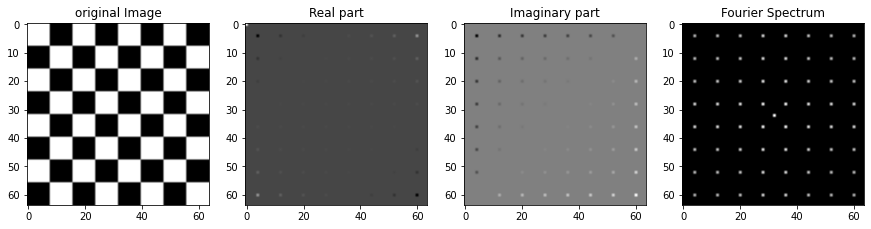

In [16]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 4, 1)
plt.imshow(grey_img1, cmap = 'gray')
plt.title('original Image')

plt.subplot(1, 4, 2)
plt.imshow(transformed.real, cmap = 'gray')
plt.title('Real part')

plt.subplot(1, 4, 3)
plt.imshow(transformed.imag, cmap = 'gray')
plt.title('Imaginary part')

centre_shifted = np.log(1 + np.abs(np.fft.fftshift(transformed)))
plt.subplot(1, 4, 4)
plt.imshow(centre_shifted, cmap = 'gray')
plt.title('Fourier Spectrum')

plt.show()

Explanation/Observations - I've used the DFT formula directly (time complxity - $O((N \cdot M)^2))$ to compute the DFT for the given image. Since a chessboard has repeating patterns vertically, horizontally, and along different possible diagonals, and there is minimal noise, we can tell that there are very specific frequencies that exist in this image. We can see in the fourier spectrum that these frequencies appear as dots at specific positions, along different axes, denoting the presence of that particular frequency in the chessboard image.

**2. Implement 1D FFT and use it to implement 2D FFT.**

In [17]:
# Size must be power of 2
def FFT_1D(x):
    N = x.shape[0]
    if N==1:
        return x
    else:
        e = np.exp((-2j*np.pi*np.arange(N))/N)
        f_even = FFT_1D(x[0 : N : 2])
        f_odd  = FFT_1D(x[1 : N : 2])
        return np.concatenate([f_even + e[:N//2] * f_odd, f_even + e[N//2:] * f_odd])

In [18]:
# Size must be power of 2
def FFT_2D(img):
    
    (l,b) = img.shape
    
    tmp1 = np.array(img).astype(complex)
    tmp2 = np.array(img).astype(complex)
    final = np.array(img).astype(complex)
    
    for i in range(l):
        row = tmp1[i,:]
        new_row = FFT_1D(row) 
        tmp2[i,:] = new_row
    
    for i in range(b):
        col = tmp2[:,i]
        new_col = FFT_1D(col)
        final[:,i] = new_col
        
    return final

In [19]:
transformed = FFT_2D(np.copy(grey_img1))

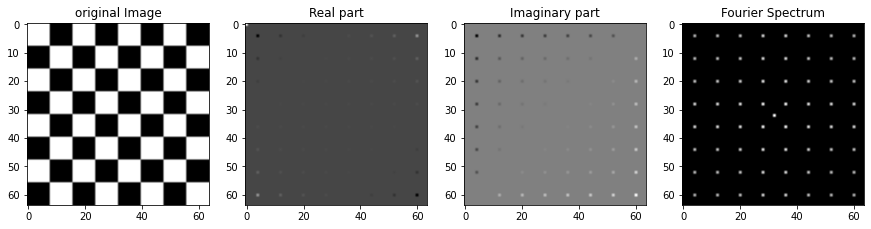

In [20]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 4, 1)
plt.imshow(grey_img1, cmap = 'gray')
plt.title('original Image')

plt.subplot(1, 4, 2)
plt.imshow(transformed.real, cmap = 'gray')
plt.title('Real part')

plt.subplot(1, 4, 3)
plt.imshow(transformed.imag, cmap = 'gray')
plt.title('Imaginary part')
centre_shifted = np.log(1 + np.abs(np.fft.fftshift(transformed)))

plt.subplot(1, 4, 4)
plt.imshow(centre_shifted, cmap = 'gray')
plt.title('Fourier Spectrum')

plt.show()

Explanation/Observations - It is evident that FFT works faster than the DFT, since it uses divide and conquer to drop down the complxity from O(N^2) to O(NlogN) in 1D case. The result obtained is exactly similar to the one obtained in the previous part.

**3. Compare the runtimes of your version of DFT and FFT on different sized images of your
choice and plot them.**

In [21]:
sizes = [8, 16, 32, 64]
t1 = []
t2 = []

for sz in sizes:
    
    img1 = cv2.imread('../images/Q4.png')
    img1 = cv2.resize(img1, (sz, sz))
    grey_img1 = convert_to_grey(img1)
    grey_img1 = grey_img1[:,:,0]
    grey_img1 = grey_img1.astype(np.uint8)
    
    lst = time.time()
    DFT_2D(grey_img1)
    t1.append(time.time()-lst)
    lst = time.time()
    
    lst = time.time()
    FFT_2D(grey_img1)
    t2.append(time.time()-lst)
    lst = time.time()    

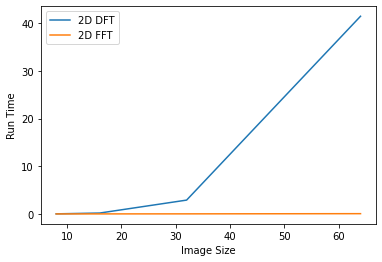

In [22]:
plt.plot(sizes, t1)
plt.plot(sizes, t2)
plt.xlabel("Image Size")
plt.ylabel("Run Time")
plt.legend(['2D DFT', '2D FFT'])
plt.show()

Explanation/Observations - As expected, the runtime of FFT is much lesser compared to DFT as the image size increases.

**4. Implement 2D Inverse FFT.**

In [23]:
# Size must be power of 2
def IFFT_1D(x):
    N = x.shape[0]
    if N==1:
        return x
    else:
        e = np.exp((2j*np.pi*np.arange(N))/N)
        f_even = IFFT_1D(x[0 : N : 2])
        f_odd  = IFFT_1D(x[1 : N : 2])
        return np.concatenate([f_even + e[:N//2] * f_odd, f_even + e[N//2:] * f_odd])

In [24]:
# Size must be power of 2
def IFFT_2D(img):
    
    (l,b) = img.shape
    
    tmp1 = np.array(img).astype(complex)
    tmp2 = np.array(img).astype(complex)
    final = np.array(img).astype(complex)
    
    for i in range(l):
        row = tmp1[i,:]
        new_row = IFFT_1D(row) 
        tmp2[i,:] = new_row
    
    for i in range(b):
        col = tmp2[:,i]
        new_col = IFFT_1D(col)
        final[:,i] = new_col
        
    return final/(l*b)

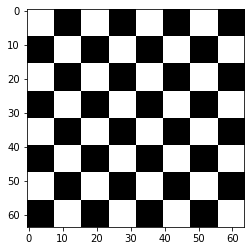

In [25]:
inv_img = IFFT_2D(transformed)
plt.imshow(inv_img.real, cmap='gray')
plt.show()

Explanation/Observations - I've directly used the inverse transformation formula to obtain the inverse image. It is important to note that the image obtained after inverse operation will be complex, so I've plotted the real part. It can be observed that the image obtained is same as the original image.

**5. Apply Fourier transform on the Fourier transform of any image of your choice and
show it.**

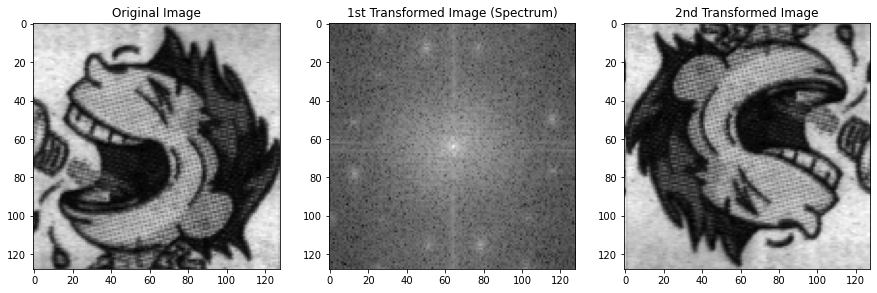

In [26]:
img = cv2.imread('../images/cart.jpg')
img = cv2.resize(img, (128, 128))
grey_img = convert_to_grey(img)
grey_img = grey_img[:,:,0]
grey_img = grey_img.astype(np.uint8)

transformed1 = FFT_2D(grey_img)
transformed2 = FFT_2D(transformed1)
centre_shifted = np.log(1 + np.abs(np.fft.fftshift(transformed1)))

plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.imshow(grey_img, cmap = 'gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(centre_shifted, cmap = 'gray')
plt.title('1st Transformed Image (Spectrum)')

plt.subplot(1, 3, 3)
plt.imshow(transformed2.real, cmap = 'gray')
plt.title('2nd Transformed Image')

plt.show()

Explanation/Observations - We obtain back the same image, but rotated by 180 degrees.

The fourier transform exists in the frequency domain and the original image is in spatial domain. To obtain an image semantically similar to the original image, we can only perform linear operations on the image in the frequency domain. (It is trivial that to get the EXACTLY same image, no changes should be made.)

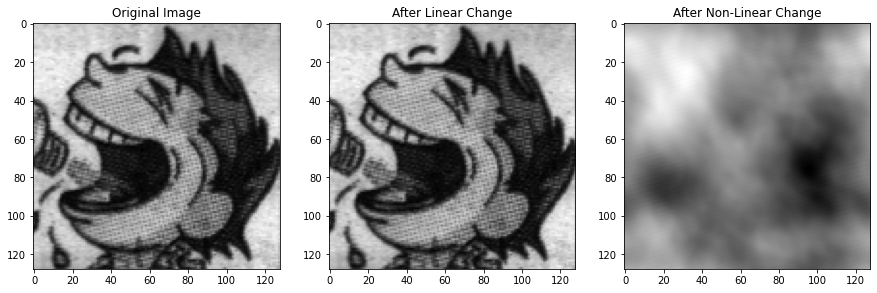

In [27]:
img = cv2.imread('../images/cart.jpg')
img = cv2.resize(img, (128, 128))
grey_img = convert_to_grey(img)
grey_img = grey_img[:,:,0]
grey_img = grey_img.astype(np.uint8)

transformed = FFT_2D(np.copy(grey_img))
inv_img1 = IFFT_2D(2*transformed+0.25j)
inv_img2 = IFFT_2D(transformed**2)

plt.figure(figsize=(15, 8))
plt.subplot(1, 3, 1)
plt.imshow(grey_img, cmap='gray')
plt.title("Original Image")
plt.subplot(1, 3, 2)
plt.imshow(inv_img1.real, cmap='gray')
plt.title("After Linear Change")
plt.subplot(1, 3, 3)
plt.imshow(inv_img2.real, cmap='gray')
plt.title("After Non-Linear Change")
plt.show()

### 5. Focused Dwight

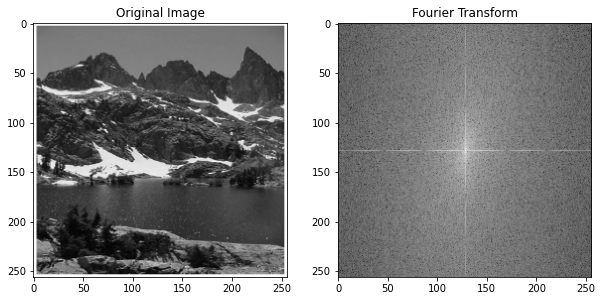

In [28]:
img = cv2.imread('../images/lakeside.jpg')
img = cv2.resize(img, (256, 256))
grey_img = convert_to_grey(img)
grey_img = grey_img[:,:,0]
grey_img = grey_img.astype(np.uint8)

F = FFT_2D(np.copy(grey_img))

plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.imshow(grey_img, cmap='gray')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(np.log(1 + np.abs(np.fft.fftshift(F))),cmap = 'gray')
plt.title("Fourier Transform")

plt.show()

**Ideal Low Pass**

In [29]:
def idealLowPass(img, radius):
    
    F = FFT_2D(img)
    shifted_F = np.fft.fftshift(F)
    [l,b] = shifted_F.shape
    transformed = np.zeros((l, b)).astype(complex)
    
    for i in range(l):
        for j in range(b):
            if (j-b/2)**2+(i-l/2)**2 <= radius**2: 
                transformed[i,j] = shifted_F[i,j]
    
    tmp = np.fft.ifftshift(transformed)
    Filtered_Image = IFFT_2D(tmp)
    return [np.log(1 + np.abs(transformed)), Filtered_Image.real]

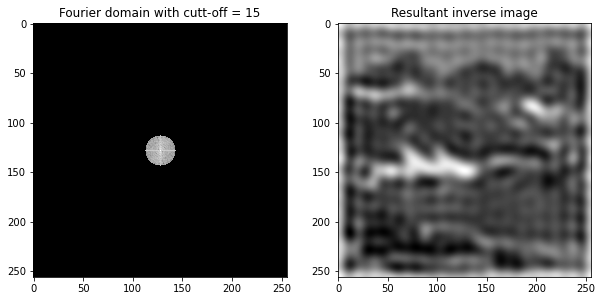

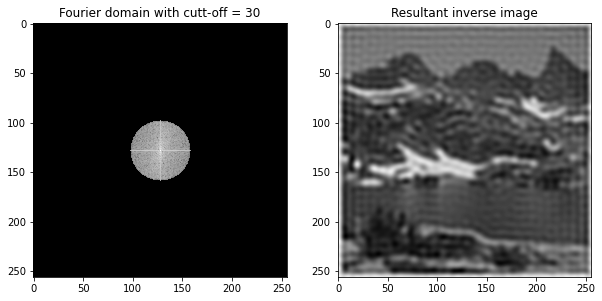

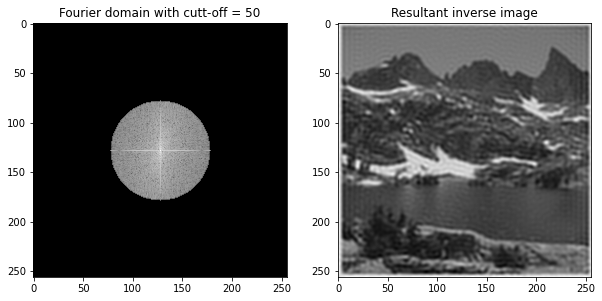

In [30]:
cutoff_radius = [15, 30, 50]

for radius in cutoff_radius:
    
    res = idealLowPass(grey_img,radius)
    
    plt.figure(figsize=(10, 8))
    
    plt.subplot(1, 2, 1)
    plt.imshow(res[0], cmap='gray')
    plt.title(f"Fourier domain with cutt-off = {radius}")

    plt.subplot(1, 2, 2)
    plt.imshow(res[1], cmap = 'gray')
    plt.title("Resultant inverse image")
    
    plt.show()

Observations - We observe that the resultant image is more blurred when the cut-off radius is smaller. This happens because, the lower the cut-off radius, more high frequency details are lost. Since edges and sharp details correspond to higher frequencies, we lose them with shorter cut-off radius.

**Gaussian Low Pass**

In [31]:
def gaussianLowPass(img,D):
    
    F = FFT_2D(img)
    shifted_F = np.fft.fftshift(F)
    [l,b] = shifted_F.shape
    transformed = np.zeros((l, b)).astype(complex)    

    for i in range(l):
        for j in range(b):
            transformed[i,j] = np.exp(-((j-b/2)**2+(i-l/2)**2)/(2*D*D))*shifted_F[i,j]
    
    tmp = np.fft.ifftshift(transformed)
    Filtered_Image = IFFT_2D(tmp)
    return [np.log(1 + np.abs(transformed)), Filtered_Image.real]

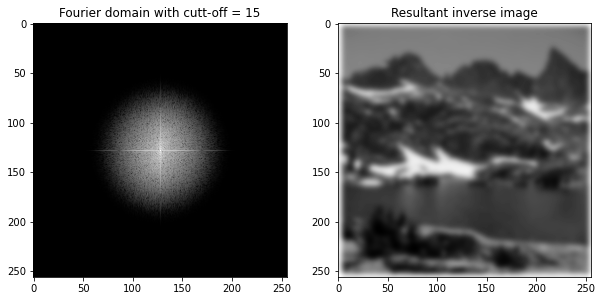

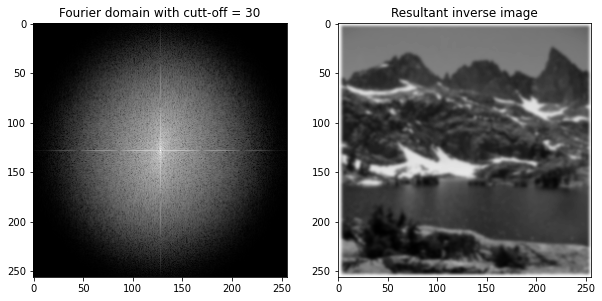

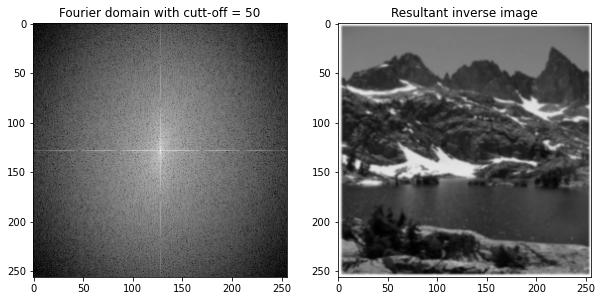

In [32]:
cutoff_radius = [15, 30, 50]

for radius in cutoff_radius:
    
    res = gaussianLowPass(grey_img, radius)
    
    plt.figure(figsize=(10, 8))
    
    plt.subplot(1, 2, 1)
    plt.imshow(res[0], cmap='gray')
    plt.title(f"Fourier domain with cutt-off = {radius}")

    plt.subplot(1, 2, 2)
    plt.imshow(res[1], cmap = 'gray')
    plt.title("Resultant inverse image")
    
    plt.show()

Observations - The resultant image is more blurred when the cut-off radius is smaller. However, the blurring is lesser compared to ideal low pass filter since the higher frequencies are gradually suppressed and not entirely dismissed. Another important observation is that the images obtained by ideal low pass filter have a ringing effect due to the sharp cut-off, which is not there in gaussian low pass.

### 6. The Broken Scanner and Smart Jim

Noises generally occur at relatively higher frequencies. Hence, to denoise an image we can cutt off (or supress) higher frequencies to get rid of the noise. However, as we have seen in the previous part, the image might appeared blurred if we use a relatively smaller cut-off radius. To sharpen the resultant image, we can apply highboost filtering on the image obtained after passing the low pass filter. It is expected that the resultant image will be denoised.

In [33]:
def denoise(img):
    res = gaussianLowPass(img, 25)
    im = res[1]
    im = np.stack((im,)*3, axis=-1).astype(float)
    im = 255.0 * (im-np.min(im))/(np.max(im)-np.min(im))
    im = im.astype(np.uint8)
    im = sharpen_img(im, 5, 5)
    return im

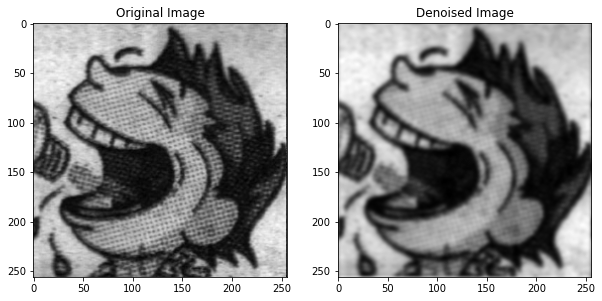

In [34]:
img = cv2.imread('../images/cart.jpg')
img = cv2.resize(img, (256, 256))
grey_img = convert_to_grey(img)
grey_img = grey_img[:,:,0]
grey_img = grey_img.astype(np.uint8)

new_img = denoise(grey_img)
plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.imshow(grey_img, cmap='gray')
plt.title(f"Original Image")

plt.subplot(1, 2, 2)
plt.imshow(new_img, cmap = 'gray')
plt.title("Denoised Image")

plt.show()